In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
data = pd.read_csv('july_2016_ontime.csv', usecols=[0,1])
data.describe()


,CARRIER,ORIGIN_STATE_ABR
count,502457,502457
unique,12,52
top,WN,CA
freq,115208,65622


In [3]:
# get the 10 most common origin states

x = pd.value_counts(data['ORIGIN_STATE_ABR'])[:10]
states = [state for state, count in x.items()]
states

['CA', 'TX', 'FL', 'GA', 'IL', 'CO', 'NY', 'AZ', 'NV', 'WA']

In [4]:
# for the 10 most common states, what are the most common airlines

data_most_common_states = data[data['ORIGIN_STATE_ABR'].isin(states)]
x = pd.value_counts(data_most_common_states['CARRIER'])[:7]
carriers = [carrier for carrier, count in x.items()]
carriers

['WN', 'AA', 'DL', 'UA', 'OO', 'EV', 'B6']

In [5]:
CARRIER_NAMES = {
    'WN': 'Southwest',
    'AA': 'American',
    'DL': 'Delta',
    'UA': 'United',
    'OO': 'SkyWest',
    'EV': 'ExpressJet',
    'B6': 'ExpressJet',
    'AS': 'Alaska',
    'NK': 'Spirit',
    'F9': 'Frontier',
    'VX': 'Virgin',
    'HA': 'Hawaiian'
}

STATE_NAMES = {
    'CA': 'California',
    'TX': 'Texas',
    'FL': 'Florida',
    'GA': 'Georgia',
    'IL': 'Illinois',
    'CO': 'Colorado',
    'NY': 'New York',
    'AZ': 'Arizona',
    'NV': 'Nevada',
    'WA': 'Washington'
}

In [6]:
data_filtered = data[data['ORIGIN_STATE_ABR'].isin(states) & data['CARRIER'].isin(carriers)]
data_filtered

,CARRIER,ORIGIN_STATE_ABR
26,AA,NY
27,AA,NY
28,AA,NY
29,AA,NY
30,AA,NY
31,AA,NY
32,AA,NY
33,AA,NY
34,AA,NY
35,AA,NY


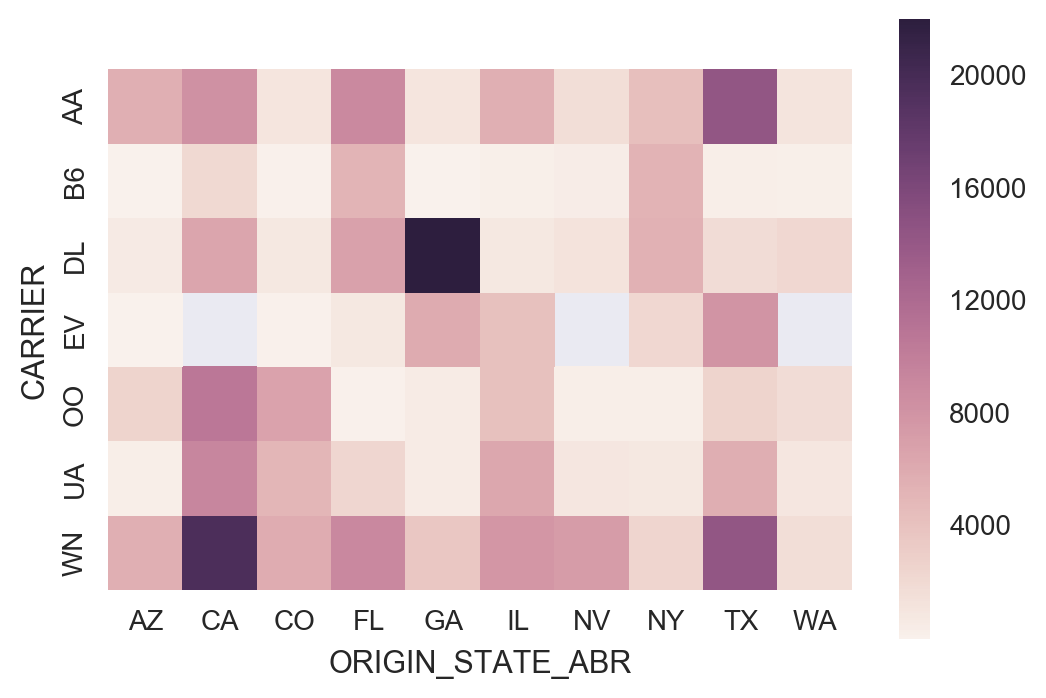

In [7]:
aggregated = data_filtered.groupby(['CARRIER', 'ORIGIN_STATE_ABR']).size().unstack()
sns.heatmap(aggregated,square=True)

In [8]:
def plot(hist, state, frac, seq):
    hist = hist.sort_values(ascending=True)
    
    matplotlib.rc('text', usetex=True)
    fig = plt.figure(figsize=(7,hist.size*0.7))
    ax = fig.add_subplot(111)
    hist.plot.barh(ax=ax, edgecolor='none', width=0.6)
    
    # title
    ax.set_title(label=r"Number of Flights out of the State of \textbf{" + STATE_NAMES[state] + "}", fontsize=18)
    ax.title.set_position([.5, 1.05])
    
    # x
    import matplotlib.ticker as plticker

    loc = plticker.MaxNLocator(nbins=7)
    ax.xaxis.set_major_locator(loc)
    ax.set_xlabel('Number of Flights', fontsize=14)
    ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    
    # y
    ax.set_ylabel('Airline', fontsize=14)
    ax.set_yticklabels(hist.keys().map(lambda x: CARRIER_NAMES[x]))
    
    fig.savefig('images/{}_{}_{}.png'.format(state, int(1/frac), seq), bbox_inches='tight', dpi=200)
    plt.close(fig)

In [9]:
# what fraction of the data to use for sample
FRACS = [0.01, 0.005, 0.002, 0.001]

# maximum number of carriers per state
LIMIT = 7

for state in states:
    for frac in FRACS:
        state_data = data[data['ORIGIN_STATE_ABR']==state]['CARRIER']

        # precise, limited
        hist = pd.value_counts(state_data)[:LIMIT]
        plot(hist, state, 1, 0)

        # top airlines from the state
        top_carriers = [carrier for carrier, count in hist.items()]

        for seq in range(1, 20):
            # approx
            sample = state_data[state_data.isin(top_carriers)].sample(frac=frac, replace=True)
            hist = pd.value_counts(sample) / frac
            plot(hist, state, frac, seq)